# Проект "Стратегия взаимодействия с клиентами на основе аналитических данных"

### ЗАДАНИЕ

#### Задача

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Клиент считается попавшим в отток, если за последний месяц ни разу не посетил спортзал. Задача — провести анализ и дать рекомендации по удержанию клиентов.
В том числе необходимо:

- разделить клиентов на несколько кластеров;
- выделить наиболее сильно влияющие на отток признаки;
- сделать выводы и дать рекомендации.

#### Инструкция по выполнению проекта

#### Шаг 1. Загрузите данные
Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на настоящий момент. Содержимое датасета:

- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

Путь к файлу у ревьюера: `/datasets/gym_churn.csv`.

#### Шаг 2. Проведите исследовательский анализ данных (EDA):
- проанализируйте отсутствующие признаки, средние значения и стандартные отклонения;  
- постройте столбчатые гистограммы и распределения признаков для тех в зависимости от факта ухода или неухода в отток;
- постройте матрицу корреляций.

#### Шаг 3. Постройте модель прогнозирования оттока клиентов
Постройте модель бинарной классификации клиентов. За целевой признак примите факт оттока.  
Обучите модель на train-выборке логистической регрессией и случайным лесом.  
Проведите оценку метрик `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке. 

#### Шаг 4. Сделайте кластеризацию клиентов
Постройте дендрограмму. На её основании определите количество кластеров.  
Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов.   
Проанализируйте кластеры.

#### Шаг 5. Сделайте выводы и дайте рекомендации по удержанию клиентов
Сделайте выводы и дайте рекомендации по удержанию клиентов.

<a id='s1'></a>
## Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.collections import PathCollection                             # для вывода непрозрачных меток легенды
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D    # для вывода непрозрачных меток легенды
from itertools import chain                                                   # для преобразования списка списков в список

In [2]:
from sklearn.model_selection import train_test_split                                               # разделитель датасета 
from sklearn.linear_model import LogisticRegression                                                # логистическая регрессия
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # метрики
from sklearn.ensemble import RandomForestClassifier                                                # случайный лес классификатор
from sklearn.preprocessing import StandardScaler                                                   # стандартизация
from scipy.cluster.hierarchy import dendrogram, linkage                                            # дендрограмма
from sklearn.cluster import KMeans                                                                 # кластеризация
from sklearn.metrics import silhouette_score                                                       # метрика силуэта

In [3]:
pth1 = '/datasets/gym_churn.csv'
pth2 = 'D:/fitness_project/gym_churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Ошибка месторасположения csv-файла "gym_churn"')

<a id='s2'></a>
## Шаг 2. Исследовательский анализ данных (EDA)

<a id='s2.1'></a>
### 2.1 Изучение датасета

In [4]:
df.info()
print()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Опишем увиденное:
- `gender` — пол, **целые числа, 0 или 1**;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр, **целые числа, 0 или 1**;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента), **целые числа, 0 или 1**;
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента), **целые числа, 0 или 1**;
- `Phone` — наличие контактного телефона, **целые числа, 0 или 1**;
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год), **целые числа**;
- `Group_visits` — факт посещения групповых занятий, **целые числа, 0 или 1**;
- `Age` — возраст, **целые числа**;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон, **вещественные числа**;
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах), **вещественные числа, нужно привести к целочисленному типу**;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах), **целые числа**;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента, **вещественные числа**;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц, **вещественные числа**;
- `Churn` — факт оттока в текущем месяце, **целые числа, 0 или 1**.

Пропусков нет.

Приведём названия столбцов к змеиному регистру.

In [5]:
df.columns = df.columns.str.lower()
df.head(1)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.22747,5.0,3,0.020398,0.0,0


Готово.

В столбцах, где должны быть только нули или единицы, проверим наличие только нулей и единиц.

In [6]:
df_one_zero = df[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']]
for col in df_one_zero.columns:
    print(df_one_zero[col].unique())

[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]


Успех.

Проверим датасет на полные дубликаты.

In [7]:
df.duplicated().sum()

0

Полных дубликатов нет, это хорошо. Если бы они были, было бы сложно отличить дубликаты от совпадений, ведь уникальных идентификаторов клиентов в датасете нет.

Изменим тип данных у столбца `month_to_end_contract` с вещественного на целочисленный.

In [8]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int32  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Готово.

Посмотрим на датасет при помощи функции `describe()`.

In [9]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


У столбцов `gender` и `partner` средние значения (и стандартные отклонения тоже) очень близки к 0.5. Значит в датасете почти поровну женщин и мужчин и почти поровну сотрудников и не сотрудников компании-партнёра (помним про скидки для сотрудников компании-партнёра).

Очень многие (~85%) клиенты живут или работают рядом в клубом (столбец `near_location`). Ещё больший процент (90%) клиентов сообщил свой контактный телефон (столбец `phone`). Это может быть полезно как дополнение к анализу, выполняемому в этом проекте. Можно позвонить и напрямую спросить, почему клиент перестал ходить на фитнес. Наверняка, иногда ответы будут касаться конкретных бытовых вопросов, которые не отражены в изучаемом датасете. 

Из столбца `promo_friends` мы видим, что почти треть клиентов воспользовалась акцией "приведи друга". То есть, работает сарафанное радио, это хорошо, потому что сэкономлен рекламный бюджет. С другой стороны, если слишком много людей воспользуется акцией, а на следующий же месяц уйдёт, мы столкнёмся с недополученной прибылью. Отсюда следует, что желательно установить оптимальный размер скидки, которая будет ощутимой для клиента и не слишком ощутимой для фитнес-клуба.

Из текста задания до конца не ясно, что действительно означает для клуба столбец `group_visits`. Есть три варианта: 1) в клубе есть групповые занятия с тренером (это должно стоить дороже) и можно заниматься самостоятельно (это должно стоить дешевле); 2) есть групповые занятия с тренером и есть индивидуальные занятия с тренером (это дороже всего); 3) есть все три вида занятий. Если верны 2-й или 3-й варианты, в датасет необходимо включить колонку об индивидуальных занятиях с тренером, чтобы не искажалась истинная картина происходящего. Примем 1-й вариант за рабочий. Групповые занятия посещает 41% клиентов. 

В только что упомянутых столбцах бывают значения только 0 и 1. Это удобно тем, что среднее значение в столбце всегда равно проценту клиентов, имеющих значение 1 в этом столбце. А ещё стандартное отклонение в таких столбцах не может быть выше 0.5.

Рассмотрим столбец `contract_period`. 

In [10]:
df['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

Действительно, абонементы есть только на месяц, полгода и год. Чуть больше половины клиентов имеют текущий абонемент длительностью на 1 месяц. Среднее значение и стандартное отклонение в итоге получились ~4.7 и ~4.5 месяцев соответственно.

Со столбцом `contract_period` в каком-то смыле связан столбец `month_to_end_contract`. Те клиенты, у кого в столбце `contract_period`, к примеру значение 6, не могут иметь в столбце значение больше 6. Это непредсказумым образом может повлиять на обучение модели. Возможно, от какого-то из этих столбцов придётся отказаться. Посмотрим на уникальные значения в столбце `month_to_end_contract` (вдруг там нет, например, значения 6) и на распределение числа клиентов по оставшимся месяцам.

In [11]:
df['month_to_end_contract'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Все значения на месте.

In [12]:
df['month_to_end_contract'].value_counts()

1     2207
6      645
12     524
11     181
5      130
10      82
9       73
4       58
8       38
7       25
3       23
2       14
Name: month_to_end_contract, dtype: int64

Заметим странную вещь. Ни у кого из клиентов, имеющих абонемент на полгода или год, не остался ровно месяц до окончания абонемента. Попытаемся найти таких клиентов.

In [13]:
df.loc[(df['contract_period'] != 1) & (df['month_to_end_contract'] == 1)]

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn


Их нет. Этому может быть несколько объяснений: 1) никто с абонементом на полгода или год так и не использовал его полностью. Косвенно на это указывает большой отрыв между теми, у кого осталось 6, 12, 11, 5 месяцев и теми, у кого осталось 3 и 2 месяца; 2) возможность купить абонемент больше, чем на месяц, появилась недавно, и ещё никто не успел потратить пять месяцев из шести; 3) это совпадение. Как бы ни было на самом деле, стоит обратить внимание, что людей, у которых осталось 3 и 2 месяца, тоже очень мало. Но, может быть, дольше всех ходят как раз те, кто обновляет абонемент каждый месяц? Хотя, конечно, не факт, что именно ***никто*** с абонементом на полгода или год так и не использовал его полностью. Вполне возможно, что такие клиенты есть/были и их текущий абонемент не является первым. Также стоит понимать, что человек, который уже сомневается в том, что хочет продолжать ходить на фитнес, может всё-таки дать клубу шанс и купить абонемент на месяц, хотя до этого покупал полугодовой/годовой.

Самое время взглянуть на столбец `lifetime`. Сразу же сравним его средние значения для тех, у кого абонемент на полгода или год, со значениями клиентов с абонементом на месяц.

In [14]:
df.loc[df['contract_period'] != 1, 'lifetime'].mean()

4.4199665365309535

In [15]:
df.loc[df['contract_period'] == 1, 'lifetime'].mean()

3.1599456275487086

Всё-таки, покупатели абонемнетов на полгода или год в среднем ходят дольше. Но для полной картины посмотрим на гистограмму.

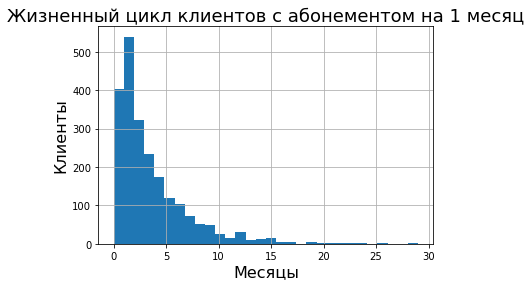

In [16]:
fig, ax = plt.subplots()
ax.grid()
plt.hist(df.loc[df['contract_period'] == 1, 'lifetime'],bins=30)
plt.xlabel('Месяцы', fontsize=16)
plt.ylabel('Клиенты', fontsize=16)
plt.title('Жизненный цикл клиентов с абонементом на 1 месяц', fontsize=18)
plt.show()

Есть настоящие долгожители. Будет надеяться, что их доли хватит модели, чтобы научиться их выявлять.

Что же касается средних значений и стандартных отклонений, в столбце `month_to_end_contract` они составили ~4.3 и ~4.2 месяца. В столбце `lifetime` ~3.72 и ~3.75 соответственно. 

Представляет интерес, что минимальное значение `lifetime` равняется 0, а не 1, как можно было бы подумать. Узнаем, сколько их.

In [17]:
len(df.loc[df['lifetime'] == 0])

487

Больше 12% от всего датасета. Есть ли кто-то, кто успел оттечь?

In [18]:
len(df.loc[(df['lifetime'] == 0) & df['churn'] == 1])

403

Таких 10% от датасета. Причём в столбце `month_to_end_contract` минимальное значение это 1. По какому принципу столько людей успели записать в отток? Был куплен абонемент, но человек ни разу не сходил на занятие, тем самым не запустив счётчик `lifetime`? Либо, что более вероятно, `lifetime` принимает значение 1 только когда первый месяц уже закончился? Если последнее предположение верно, то, так как месяц для тех, у кого `lifetime = 0`, ещё не закончился, рано записывать людей в отток. А ещё при `lifetime = 0` значения столбцов `month_to_end_contract` и `contract_period` должны совпадать. Проверим, так ли это для случаев `churn = 0` и `churn = 1`.

In [19]:
df.loc[(df['lifetime'] == 0) & (df['churn'] == 1) & (df['month_to_end_contract'] != df['contract_period'])]

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
72,1,1,1,1,1,6,0,29,134.564112,5,0,1.725835,0.894815,1
94,0,1,0,0,1,6,1,21,232.939550,5,0,2.175458,1.371496,1
95,1,1,0,0,1,6,0,25,101.702604,5,0,0.669806,0.363487,1
128,1,0,1,0,1,6,0,29,291.731275,5,0,0.000000,0.000000,1
1058,0,1,0,1,1,6,0,25,62.922411,5,0,2.223131,1.338029,1
1087,1,1,0,0,1,6,0,22,162.446888,5,0,1.326791,0.125039,1
1344,0,0,0,0,1,6,0,28,74.245231,5,0,1.137114,1.507663,1
1746,0,1,1,1,1,6,0,27,179.048374,5,0,1.531032,2.011963,1
2472,1,1,1,0,1,12,0,33,76.941459,9,0,2.313958,1.850308,1
2663,1,1,0,0,1,6,0,25,37.170637,4,0,1.905592,1.608635,1


In [20]:
df.loc[(df['lifetime'] == 0) & (df['churn'] == 0) & (df['month_to_end_contract'] != df['contract_period'])]

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
71,0,1,1,1,1,12,0,26,174.978054,11,0,1.061644,1.027229,0
187,0,1,1,1,1,6,1,27,292.228609,4,0,1.047561,1.087670,0
193,0,0,1,0,0,6,0,33,53.124270,5,0,2.993532,2.910934,0
697,0,1,1,1,1,12,1,28,84.028681,10,0,0.000000,0.000000,0
845,0,1,0,0,1,6,0,28,134.974794,5,0,1.324323,1.336012,0
1229,1,1,1,0,1,12,1,35,71.640849,11,0,1.551066,1.466990,0
1400,1,1,0,0,1,6,1,31,462.178660,5,0,2.504586,2.453484,0
1640,0,1,1,0,1,12,1,31,232.271614,9,0,0.530804,0.578268,0
2152,1,1,1,1,1,12,0,32,242.040987,11,0,3.142519,3.057465,0
2374,0,1,1,1,1,12,0,32,248.424920,11,0,1.889913,2.025785,0


Нам удалось обнажужить оба случая. Причём иногда значения `month_to_end_contract` и `contract_period` отличаются более, чем на 1 месяц. Теперь факт записи или не записи в отток можно объяснить разве что конретным ответом клиента на вопрос, собирается ли он начать (или продолжать) ходить на фитнес. Если бы мы разбирали реальный кейс, то следовало бы выяснить у ответственных за это людей, по каким принципам меняются значения в столбцах `lifetime` и `churn`. Возможно, эти приципы не логичны или не соблюдаются.

Так как случаев, когда `month_to_end_contract` и `contract_period` различаются при `lifetime = 0` в целом немного и они почти поровну поделены между `churn = 0` и `churn = 1`, ничего не будем менять в датасете.

Кроме того, неясности добавляет расшифровка столбца `avg_class_frequency_current_month` — "средняя частота посещений в неделю за предыдущий месяц". По идее там стоят нули в двух случаях: когда клиент действительно не пришёл ни разу за прошлый месяц и когда человек ещё не был клиентом. Во втором случае данные будут искажены.

In [21]:
len(df.loc[df['avg_class_frequency_current_month'] == 0])

181

Есть 181 случай, когда частота посещений в "предыдущем" месяце равняется нулю. Сколько из них, вероятно не были клиентами в предыдущем месяце?

In [22]:
len(df.loc[(df['avg_class_frequency_current_month'] == 0) & (df['lifetime'] == 0)])

54

54 человека. А сколько из них успехи попасть в отток.

In [23]:
len(df.loc[(df['avg_class_frequency_current_month'] == 0) & (df['lifetime'] == 0) & (df['churn'] == 0)])

1

Даже тут кто-то есть. Получается, насчёт столбца `avg_class_frequency_current_month` тоже нужно поинтересоваться.

А ещё можно посмотреть, совпадают ли значения `avg_class_frequency_current_month` и `avg_class_frequency_total` при `lifetime = 0` и `lifetime = 1`.

In [24]:
df.loc[df['lifetime'] == 0].head(3)


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
7,0,1,0,0,1,1,0,30,217.786641,1,0,1.213502,1.049387,1
16,0,1,1,1,1,1,1,31,11.975295,1,0,3.342261,3.206223,0
25,0,0,0,0,1,1,0,29,57.730007,1,0,1.491187,1.246807,1


In [25]:
df.loc[df['lifetime'] == 1].head(3)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
8,1,1,1,1,1,1,1,23,45.409909,1,1,1.106239,1.059333,0
13,1,1,0,0,1,1,1,27,152.748668,1,1,0.000000,0.000000,1
17,0,1,0,1,1,6,1,29,92.787414,5,1,0.664482,0.609945,0


И даже тут есть расхождения, особенно если обратить внимание на ситуацию, когда клиент при `lifetime = 0` имеет ненулевое значение в столбце `avg_class_frequency_current_month` и при этом попал в отток.

Посмотрим столбец `age` и его распределение.

In [26]:
df['age'].value_counts()

29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: age, dtype: int64

Среднее значение и стандартное отклонение в столбце `age` составляют ~29.2 и ~3.2 лет, ничего примечательного. Распределение тоже не вызывает вопросов.

Также ничего примечательного нет в средних значениях и стандартных отклонениях у столбцов `avg_additional_charges_total` (147 и 96), `avg_class_frequency_total` (1.9 и 1) и `avg_class_frequency_current_month` (1.8 и 1.1). Про среднюю посещаемость менее двух раз в неделю можно сказать, что она низкая. Возможна ситуация, когда клиента не вдохновили ходить почаще, за несколько месяцев он так и не привёл себя в форму, расстроился и совсем перестал ходить на фитнес.

<a id='s2.2'></a>
### 2.2 Cредние значения признаков в двух группах (churn=0, churn=1)

Как этого требует задание, посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [27]:
df.groupby('churn').mean().round(3)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510,0.873,0.534,0.354,0.904,5.747,0.464,29.977,158.446,5.283,4.712,2.025,2.028
1,0.511,0.768,0.355,0.184,0.903,1.729,0.269,26.990,115.083,1.663,0.991,1.475,1.045


Практически одинаковые средние значения мы наблюдаем по признакам `gender` и `phone`. Меньше отток среди тех, кто:
- живёт или работает возле фитнес-клуба;
- является сотрудником компании-партнёра клуба;
- пришёл по акции "приведи друга";
- посещает групповые занятия;
- старше;
- больше тратит на дополнитеные услуги;
- имеет меньший срок до конца абонемента;
- чаще ходит (причём недельная посещаемость в месяц, предшествующий тому, когда клиент бросает фитнес, падает почти в полтора раза по сравнению с посещаемостью за всё время);
- ходит дольше (суперлогично).
Вышеперечисленные наблюдения не вызывают вопросов. Сомнения могли быть разве что касательно столбца с возрастом. 

Особняком в разделении на две группы стоит столбец `contract_period`. Так как не существует абонементов на 2-5 и 7-11 месяцев, столбец нельзя в полной мере считать численным. Он скорее является категориальным. Поэтому отток нужно в том числе посмотреть, исходя из количества людей в разных категориях и притом безотносительно "веса" их текущего абонемента.

In [28]:
df.pivot_table(index='contract_period', values='churn').round(3)

,churn
contract_period,
1,0.423
6,0.125
12,0.024


42% клиентов, купивших в текущем месяце абонемент на месяц, уйдут в отток. Из тех, кто купил на полгода, уйдёт каждый восьмой. Из обладателей годового абонемента - каждый 42-й. Может быть, стоит дарить "полугодникам" мерч фитнес-клуба или как-то ещё их поощрять, если, когда придёт время, они купят абонемент ~~на полгода~~ на год. "Бесплатная" футболка может переманить их в более оттокоустойчивую категорию.

In [29]:
df.loc[(df['lifetime'] == 0) & (df['month_to_end_contract'] == df['contract_period'])]

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
7,0,1,0,0,1,1,0,30,217.786641,1,0,1.213502,1.049387,1
16,0,1,1,1,1,1,1,31,11.975295,1,0,3.342261,3.206223,0
25,0,0,0,0,1,1,0,29,57.730007,1,0,1.491187,1.246807,1
39,1,1,0,1,0,6,1,35,233.239548,6,0,1.270752,1.206591,0
46,1,1,0,0,1,1,0,26,54.184236,1,0,0.854079,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3971,1,1,0,0,1,1,0,27,60.636243,1,0,0.755127,0.000000,1
3976,1,1,0,0,1,1,0,28,104.472327,1,0,1.310044,1.055181,1
3977,1,1,0,0,1,1,0,29,93.817092,1,0,0.444837,0.000000,1
3982,1,1,0,0,1,1,0,24,135.395712,1,0,1.390251,0.789321,1


<a id='s2.3'></a>
### 2.3 Cтолбчатые гистограммы и распределения признаков для ушедших и оставшихся

Построим гистограммы для всех столбцов в датасете в зависимости от показателя `churn`.

In [30]:
df_churn_0 = df.loc[df['churn'] == 0]
df_churn_1 = df.loc[df['churn'] == 1]

In [31]:
def churn_hist(col):
    plt.hist([df_churn_0[col], df_churn_1[col]], label=['churn = 0', 'churn = 1'])
    plt.xlabel(col, fontsize=16)
    plt.ylabel('clients quantity', fontsize=16)
    plt.title(col, fontsize=18)
    plt.legend(loc='upper right')
    plt.show()

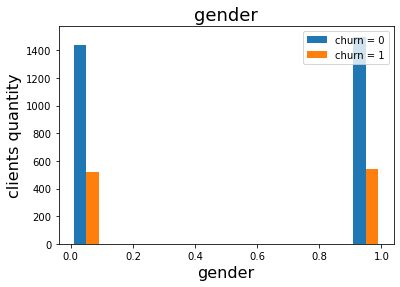

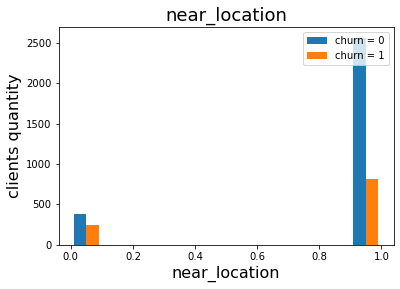

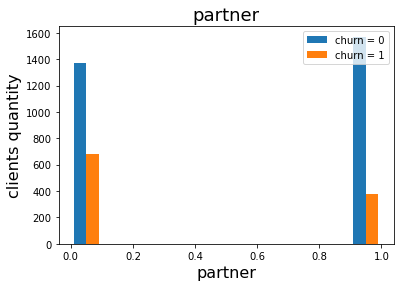

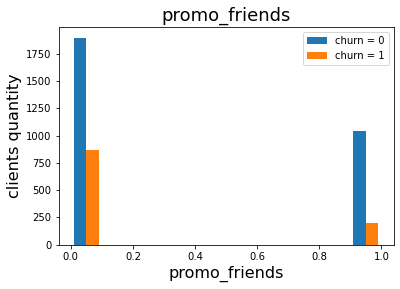

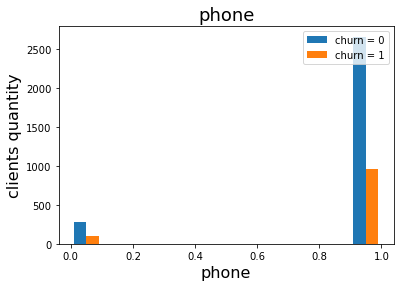

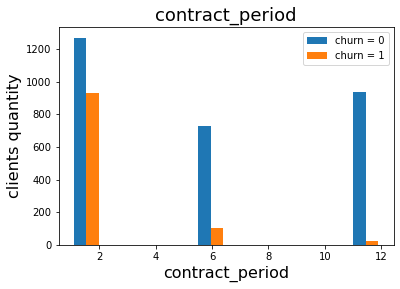

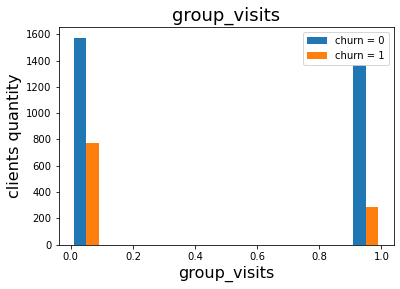

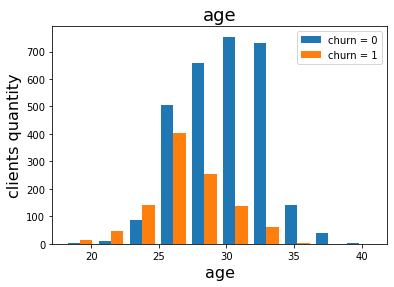

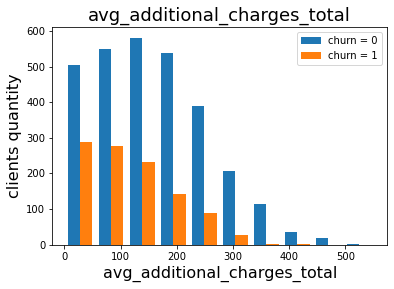

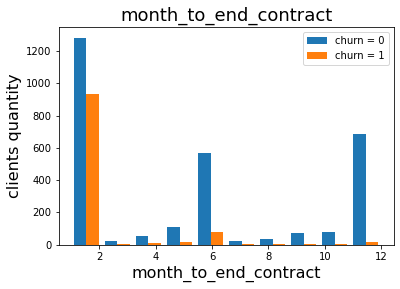

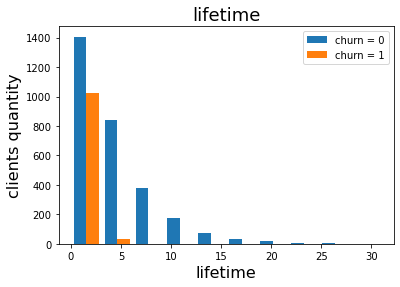

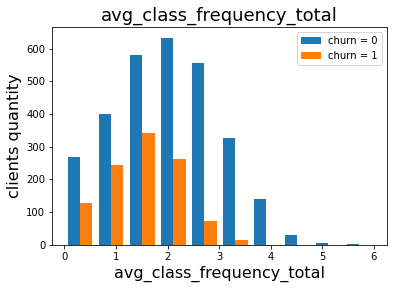

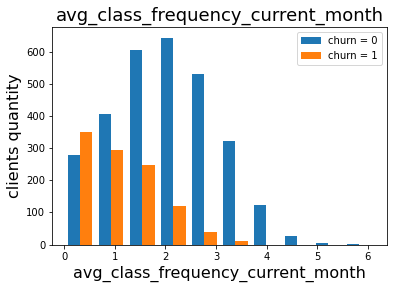

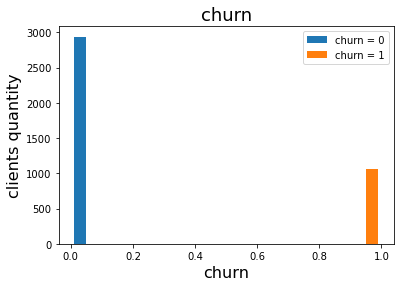

In [32]:
for i, j in zip(df_churn_0, df_churn_0):
    churn_hist(i) 

Опишем увиденное:
- `gender`, `phone` - для разных значений соотношения оттоков практически равные;
- `near_location`, `partner`, `promo_friends`, `group_visits` - соотношение оттоков явно лучше при значении 1;
- `contract_period` - чем больше контрактный период, тем меньше вероятность оттока;
- `age` - оба распределения похожи на перевёрнутые параболы. Парабола оттока сдвинута в сторону меньших возрастов;
- `avg_additional_charges_total` - немного разные формы распределений : у "неоттока" пик распределения смещён в сторону больших трат, у "оттока" пик приходится на околонулевые траты;
- `month_to_end_contract` - чем больше осталось месяцев, тем меньше вероятность оттока;
- `lifetime` - распределения похожи по форме;
- `avg_class_frequency_total` - у "оттока" пик распределения в области чуть меньших значений, чем у "неоттока"
- `avg_class_frequency_current_month` - клиенты, попавшие в отток, в последний месяц ходят на занятия значительно реже.

Построим диаграммы рассеяния для столбцов, где значения не ограничиваются нулями и единицами. Для столбца `contract_period` диаграмму тоже не имеет смысла делать.

In [33]:
scatter_columns_list = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',\
                        'avg_class_frequency_total', 'avg_class_frequency_current_month']

In [34]:
def churn_scatter(col):
    if col in scatter_columns_list:
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.scatter(df_churn_0['churn'], df_churn_0[col], color='blue', label='churn = 0', alpha=0.01)
        ax1.scatter(df_churn_1['churn'], df_churn_1[col], color='orange', label='churn = 1', alpha=0.01)
        plt.xlabel('churn or not', fontsize=16)
        plt.ylabel(col, fontsize=16)
        plt.title(col, fontsize=18)
        # для вывода непрозрачных меток легенды:
        def update(handle, orig):
            handle.update_from(orig)
            handle.set_alpha(1)
        plt.legend(loc='center', handler_map={PathCollection : HandlerPathCollection(update_func= update),
                        plt.Line2D : HandlerLine2D(update_func = update)})
        plt.show()
    else:
        pass

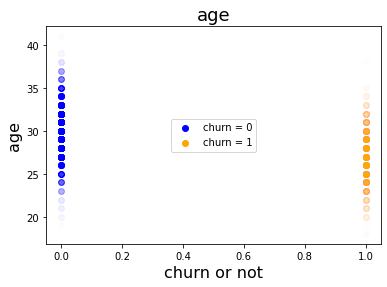

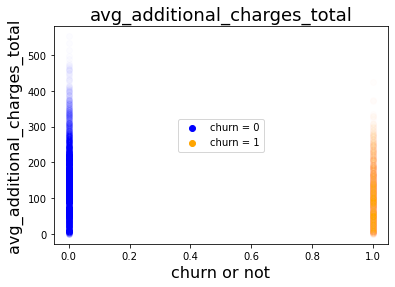

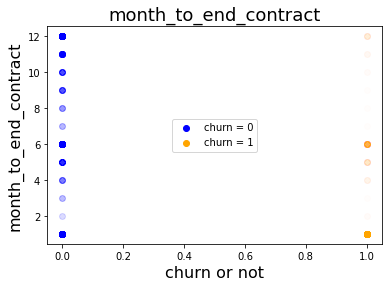

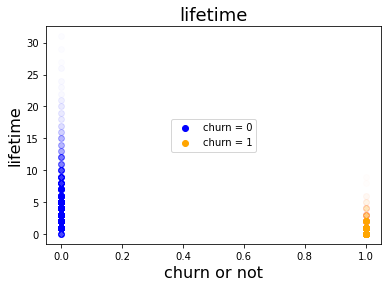

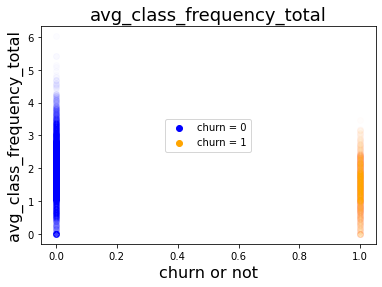

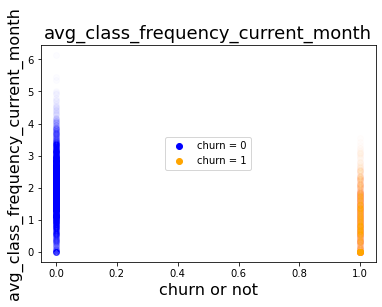

In [35]:
for i, j in zip(df_churn_0, df_churn_0):
    churn_scatter(i) 

Ничего противоречащего написанному после недавних гистограмм.

<a id='s2.4'></a>
### 2.4 Матрица корреляций

Выведем таблицу с корреляциями и хитмэп с ними же.

In [36]:
df.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


<AxesSubplot:>

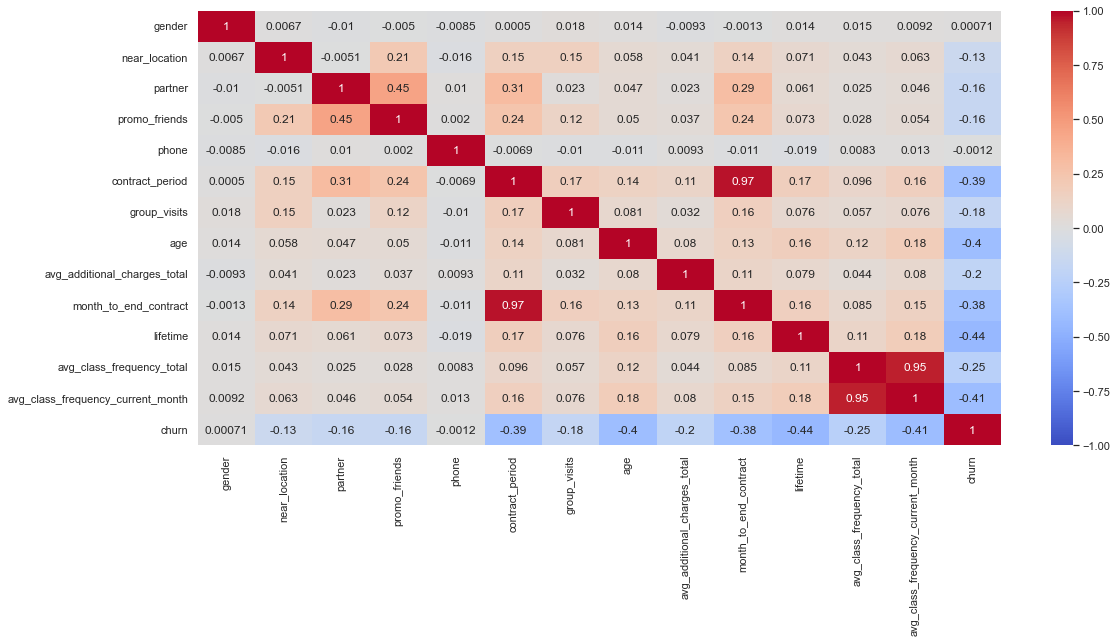

In [37]:
sns.set(rc = {'figure.figsize':(18,8)})
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

У нас есть столбцы-рекордсмены по корреляции: `month_to_end_contract` в паре с `contract_pediod` (0.97) и `avg_class_frequency_total` в паре с `avg_class_frequency_current_month` (0.95). Огромная корреляция в первой паре обусловлена в первую очередь тем, что больше половины абонементов - на один месяц. Вдобавок к этому отсутствует возможность покупки абонементов на 2, 3, 4 и т.п. месяцев, что снизило бы корреляцию. Касательно второй пары: не удивительно, если клиент в последний месяц будет ***почти*** так же часто, как и всегда. К тому же, для многих клиентов понятие "за всё время" совпадает с "последним месяцем".

Не будем сразу же удалять по одному столбцу из пар с большой корреляцией. Сначала посмотрим, какие веса назначат для них модели. Может быть, они будут адекватными, и нам удастся сохранить важные признаки?

Достойная внимания корреляция есть между столбцами `partner` и `promo_friends` (0.45). Наверно, эти две скидки можно складывать, что и способствует сарафанному радио между коллегами.

Нет положительных корреляций со столбцом `churn`. Ранее мы уже писали среди кого меньше отток. Повторим те же слова, подставив корреляции по каждому пункту.

Практически одинаковые средние значения мы наблюдаем по признакам `gender` (0.00071) и `phone` (минус 0.0012). Меньше отток среди тех, кто:
- живёт или работает возле фитнес-клуба (минус 0.13);
- является сотрудником компании-партнёра клуба (минус 0.16);
- пришёл по акции "приведи друга" (минус 0.16);
- посещает групповые занятия (минус 0.18);
- старше (минус 0.4);
- больше тратит на дополнитеные услуги (минус 0.2);
- имеет меньший срок до конца абонемента (минус 0.38);
- чаще ходит (причём недельная посещаемость в месяц, предшествующий тому, когда клиент бросает фитнес (минус 0.41), падает почти в полтора раза по сравнению с посещаемостью за всё время) (минус 0.25);
- ходит дольше (суперлогично) (минус 0.44).

Корреляция оттока с `contract_pediod` составляет минус 0.39. Это говорит о том, что клиенты, купившие абонемент на полгода или год, скорее всего бросят фитнес не в первый месяц.

Ещё из хитмэпа видно, что у столбцов `gender` и `phone` пратически нет корреляции не только с оттоком, но и с остальными столбцами. Отсюда вопрос, нужны ли они вообще, т.е. смогут ли они быть хоть сколько-нибудь полезными про обучении модели? Или только потратят зря вычислительные ресурсы? Или внесут лишний вклад в потенциальное переучивание модели?

Теперь построим, наконец, матрицу корреляций. В ней эмпирическим путём подберём только те столбцы, распределения которых хотя бы как-то можно будет интерпретировать.

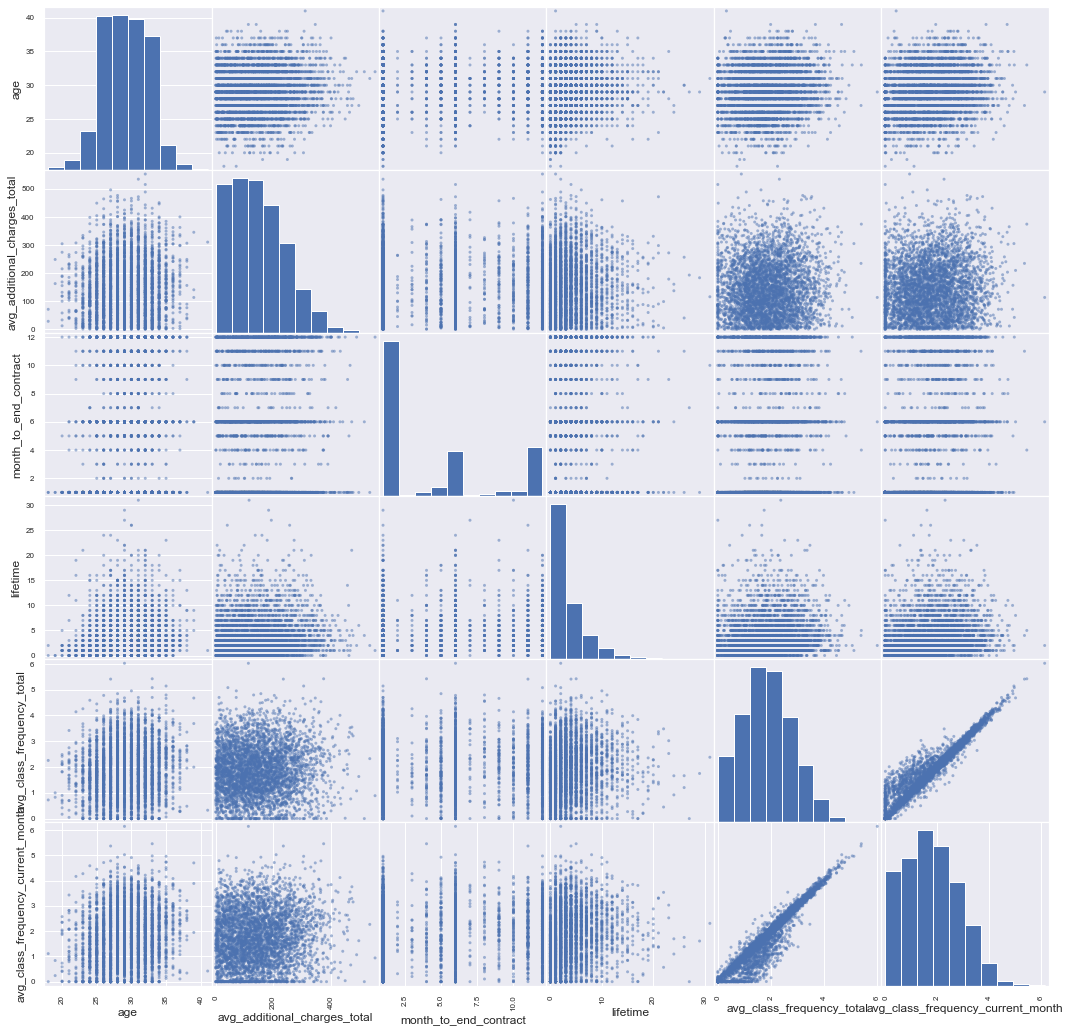

In [38]:
pd.plotting.scatter_matrix(df[['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',\
                        'avg_class_frequency_total', 'avg_class_frequency_current_month']], figsize=(18, 18))
plt.show()

Не видно ничего, противоречащего тому, что мы увидели на хитмэпе с корреляцими. Особенно хорошо прослеживается описанная выше корреляция между столбцами `avg_class_frequency_total` и `avg_class_frequency_current_month`.

<a id='s3'></a>
## Шаг 3. Модель прогнозирования оттока клиентов

<a id='s3.1'></a>
### 3.1 Разбиение датасета на выборки

Разобьём датасет на обучающую (`train`) и валидационную (`test`) выборки. 

In [39]:
y = df['churn']
X = df.drop(['churn'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Узнаем, насколько похожи обучающая и валидационные выборки. Построим графики функции плотности вероятности.

<AxesSubplot:xlabel='churn', ylabel='Density'>

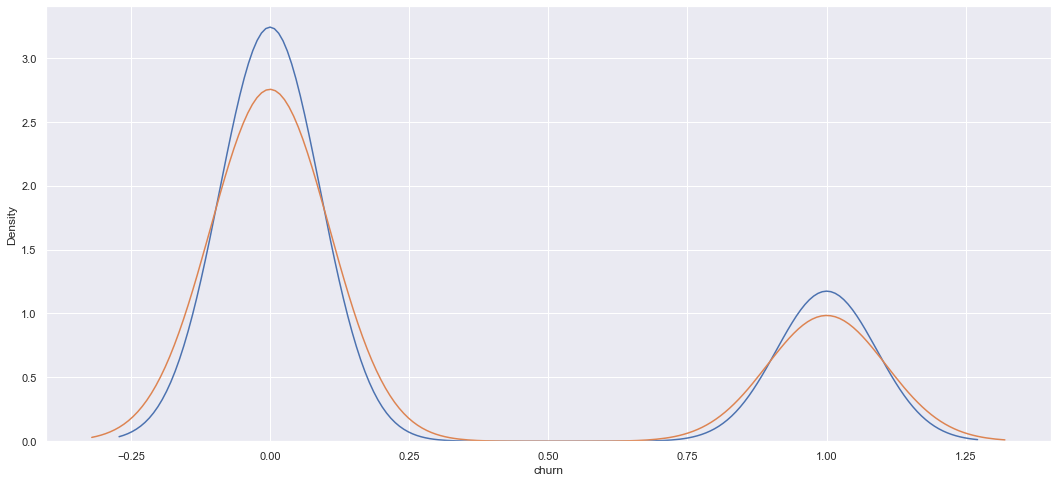

In [40]:
sns.kdeplot(y_train)
sns.kdeplot(y_test) 

Графики получились не очень хорошими (в идеале они должны наложиться друг на друга), что может негативно отразиться на стандартизации. Если ещё сильнее увеличить долю валидационной выборки, графики сблизятся, но доля в 30% - это и так много.

Стандартизируем выборки и проверим успешность стандартизации: среднее значение должно равняться (или почти равняться) нулю, стандартное отлонение должно равняться (или почти равняться) 1. Проверку проведём на случайном столбце, пусть это будет нулевой.

In [41]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)       
print('Mean for standartized train:', np.mean(X_train_st[:,0]))
print('Std for standartized train:', np.std(X_train_st[:,0]))
print('Mean for standartized test:', np.mean(X_test_st[:,0]))
print('Std for standartized test:', np.std(X_test_st[:,0]))

Mean for standartized train: 3.8064789415719655e-18
Std for standartized train: 0.9999999999999999
Mean for standartized test: 0.0016670001000333467
Std for standartized test: 0.9999652632800112


Успешно.

<a id='s3.2'></a>
### 3.2 Обучение модели методом логистической регрессии

Обучим модель логистической регресией.

In [42]:
lr_model = LogisticRegression(solver='liblinear') # "solver='liblinear'" чтобы не было предупреждения
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1] # берём только вторые числа из вектора пар вероятностей

Проверим какие веса получили признаки (мы запланировали это, когда не стали сразу удалять столбцы из-за высокой корреляции). Нас интересуют пары `contract_period` - `month_to_end_contract` и `avg_class_frequency_total` - `avg_class_frequency_current_month`.

In [43]:
list_columns = list(df.columns.drop(['churn']))
list_coef = list(chain.from_iterable(lr_model.coef_))
columns_coef = pd.DataFrame({'coef': list_coef, 'columns': list_columns})
columns_coef

,coef,columns
0,-0.033181,gender
1,-0.079905,near_location
2,-0.092604,partner
3,-0.287309,promo_friends
4,0.009956,phone
5,-0.768316,contract_period
6,-0.424054,group_visits
7,-1.084539,age
8,-0.513514,avg_additional_charges_total
9,-0.507067,month_to_end_contract


С первой парой всё в порядке. А вот со второй нет: веса получились разных знаков, т.е. модель компенсирует один признак другим, чего не должно происходить, ведь на самом деле они в положительной корреляции. Нам придётся удалить один из признаков из второй пары. Мы  удалим `avg_class_frequency_total`, оставив `avg_class_frequency_current_month` как более актуальный.

Учитывая, что за частоту посещений теперь отвечает только `avg_class_frequency_current_month`, становится особенно важным разобраться с тем, как он заполняется (об этом речь шла выше).

Переобучим модель, удалив признак `avg_class_frequency_total`, и посмотрим на новые веса признаков.

In [44]:
X_clear = df.drop(['churn', 'avg_class_frequency_total'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_clear, y, test_size=0.3, random_state=0)

In [45]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)        
print('Mean for standartized train:', np.mean(X_train_st[:,0]))
print('Std for standartized train:', np.std(X_train_st[:,0]))
print('Mean for standartized test:', np.mean(X_test_st[:,0]))
print('Std for standartized test:', np.std(X_test_st[:,0]))

Mean for standartized train: 3.8064789415719655e-18
Std for standartized train: 0.9999999999999999
Mean for standartized test: 0.0016670001000333467
Std for standartized test: 0.9999652632800112


In [46]:
lr_model = LogisticRegression(solver='liblinear') # "solver='liblinear'" чтобы не было предупреждения
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1] # берём только вторые числа из вектора пар вероятностей

In [47]:
list_columns = list(df.columns.drop(['churn', 'avg_class_frequency_total']))
list_coef = list(chain.from_iterable(lr_model.coef_))
columns_coef = pd.DataFrame({'coef': list_coef, 'columns': list_columns})
columns_coef

,coef,columns
0,0.026579,gender
1,-0.087083,near_location
2,-0.081918,partner
3,-0.257374,promo_friends
4,-0.067785,phone
5,-0.861426,contract_period
6,-0.409237,group_visits
7,-1.090976,age
8,-0.546422,avg_additional_charges_total
9,-0.540795,month_to_end_contract


Теперь веса признаков адекватны.

<a id='s3.3'></a>
### 3.3 Несколько замечаний насчёт метрик

Метрика `accuracy (точность)` - доля верно угаданных ответов. Работает только при условии баланса классов — когда объектов каждого класса примерно поровну. В нашем случае доля `churn = 0` должная быть равна доле `churn = 1`. Посмотрим, что у нас с балансом.

In [48]:
print('Доля "churn = 1" в обучающей выборке:', y_train.mean())
print('Доля "churn = 1" в валидационной выборке:', y_test.mean())

Доля "churn = 1" в обучающей выборке: 0.26607142857142857
Доля "churn = 1" в валидационной выборке: 0.2633333333333333


С балансом всё в порядке, отличие составило менее 0.3%.

Метрика `precision (ещё одна точность)` - доля правильных ответов только среди целевого класса (`churn = 1`). В нашем случае эта метрика будет особо важна, например, если, доверяя прогнозу о том, что конкретный клиент скоро уйдёт в отток, фитнес-клуб постарается уговорить клиента остаться каким-то способом, который будет стоить денег финтнес-клубу. Нелогично одаривать тех, кто и так не собирается уходить.

Метрика `recall (полнота)` - доля обнаруженных реальных объектов целевого класса. Эта метрика полезна, если бизнесу выгоднее предпринять какие-то меры для уменьшения оттока, пусть даже покрывая тех, кто не собирался уходить, чем этого не сделать.

Метрика `F1-score (F1-мера)` - сводная метрика, учитывающая баланс между точностью и полнотой, которые противоположны по сути. Вычисляется по формуле `f1_score = 2 * precision * recall / (precision + recall)`. Посчитаем её тоже, она ещё пригодится при подборе порога определения бинарных классов.

Метрика `roc_auc (площадь под кривой ошибок)` - показывает, насколько хорошо выделяются классы, если отсортировать объекты по вероятности, которую спрогнозировала модель. Метрика хорошо подходит даже для несбалансированных классов. Если метрика достаточно высокая, значит можно подобрать такой порог, чтобы выросли другие метрики. Под порогом понимается граница между вероятностями отнесения к тому или иному классу. Если метрика недостаточно высокая, можно попробовать обучить модель каким-нибудь другим методом.

In [49]:
print('Метрики для модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, lr_predictions)))
print('roc_auc: {:.2f}'.format(roc_auc_score(y_test, lr_probabilities)))

Метрики для модели логистической регрессии:
Accuracy: 0.91
Precision: 0.82
Recall: 0.84
F1: 0.83
roc_auc: 0.96


Метрики выглядят неплохими, но, прежде чем делать выводы, стоит дождаться этих метрик для другой модели.

<a id='s3.4'></a>
### 3.4 Обучение модели методом случайного леса.

Обучим модель методом случайного леса. Методом подбора найдём выгодное число деревьев (`n_estimators`).

In [50]:
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('roc_auc: {:.2f}'.format(roc_auc_score(y_true, y_pred)))
        
rf_model = RandomForestClassifier(n_estimators = 40, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

print_all_metrics(y_test, rf_predictions, title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
Accuracy: 0.90
Precision: 0.83
Recall: 0.78
F1: 0.81
roc_auc: 0.86


Все метрики, кроме `precision` (отличие на 1 процентный пункт), лучше у модели, обучавшейся методом логистической регрессии, поэтому дальше работать будем именно с ней.

<a id='s3.5'></a>
### 3.5 Подбор порога

Подберём порог для определения бинарных классов для модели, обучавшейся методом логистической регрессии. Ориентироваться будем на метрику `F1-score`, как учитывающую и `precision`, и `recall`. Если и когда будет принято решение относительно тактики уменьшения оттока, порог можно будет подобрать заново.

*Для экономии места не будем приводить здесь процесс подбора, а оставим только вариант с самым удачным порогом.*

In [51]:
probabilities = lr_model.predict_proba(X_test_st)[:, 1]
threshold = 0.51      
custom_predictions = [0 if i < threshold else 1 for i in probabilities]

In [52]:
print('Метрики для прогноза с кастомным порогом:')
print('Accuracy for custom: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precision for custom: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Recall for custom: {:.2f}'.format(recall_score(y_test, custom_predictions)))
print('F1 for custom: {:.2f}'.format(f1_score(y_test, custom_predictions)))

Метрики для прогноза с кастомным порогом:
Accuracy for custom: 0.91
Precision for custom: 0.83
Recall for custom: 0.83
F1 for custom: 0.83


Увеличить `F1-score` не удалось, но удалось уравнять `precision` и `recall` между собой. Для работы в дальнейшем будем использовать кастомную модель, обученную методом логистической регрессии.

<a id='s4'></a>
## Шаг 4. Кластеризация клиентов

<a id='s4.1'></a>
### 4.1 Кластеризация и дендрограмма

Так как кластеризация подразумевает обучение без учителя, временно будем использовать датасет без столбца `chain`.

In [53]:
# df = df.drop(['avg_class_frequency_total'], axis=1) # раскомментить, если столбец нужно удалить и для кластеризации тоже
dfc = df.drop(['churn'], axis=1)

Мы уже стандартизировали данные, но тогда они были разделены на выборки. А сейчас нет никакого смысла их разделять, поэтому стандартизируем их снова, но уже не разделяя.

In [54]:
X_sc = scaler.fit_transform(dfc)

Строим дендрограмму.

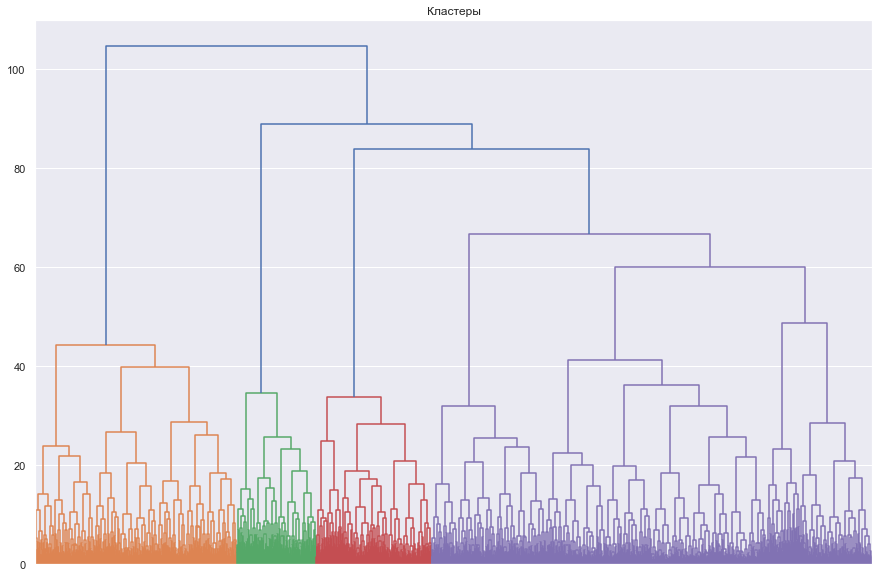

In [55]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Кластеры')
plt.show() 

Датасет разделился на 4 кластера. Зададим модель на основании алгоритма K-means. Применим алгоритм к данным и сформируем вектор кластеров. Создадим столбец с кластерами в датасете. И посчитаем метрику силуэта. (Метрика силуэта показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой.)

In [56]:
km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(X_sc)
df['cluster'] = labels
silhouette_score(X_sc, labels)

0.13431299434653673

Метрика силуэта получилась, мягко говоря, так себе (0.13 при теоретически идеальной равной 1). Поэтому не стоит ожидать от кластеризации многого. Глянем, как распределилсь кластеры. 

In [57]:
df['cluster'].value_counts()

1    1479
3    1078
2    1057
0     386
Name: cluster, dtype: int64

Самый меньший из них составляет почти 10% от датасета, что сочтём допустимым. Сгруппируем данные по кластерам, посчитаем средние значения для всех столбцов и отсортируем по возрастанию оттока.

In [58]:
df.groupby('cluster').mean().sort_values(by='churn')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032,9.768089,4.730056,1.983884,1.975592,0.029685
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764,2.239357,4.704825,2.724796,2.711132,0.092715
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525,1.805274,2.235294,1.204610,0.951590,0.559838


Особый интерес представляет столбец `phone`, где присутствуют значения ровно 0 и ровно 1. Это значит, что соответствующий признак был сочтён очень важным. Впрочем, нулевой кластер, где среднее значение составило 0, не имеет самый низкий или высокий отток.

Возможно, если бы во всех столбцах значения были бы бинарными, мы бы увидели ещё пару примеров такой кластеризации.

В целом кластеризацию нельзя признать действительно удачной, потому что только три столбца оказались отсортированы: `group_visits`, `avg_additional_charges_total` и `lifetime`.

Что касается остальных признаков (столбцов), сложно проследить в них какой-то порядок. Может быть, их просто слишком много, чтобы какой-то признак стал определяющим. А может быть, просто стоит попробовать построить гистограммы.

<a id='s4.2'></a>
### 4.2 Гистограммы

Построим гистограммы для каждого столбца и для каждого кластера. Для экономии места на экране не будем подписывать оси у каждой гистограммы, просто запомним, что на оси Х - значения столбца, упомянутого в заголовке, а на оси Y количество клиентов.

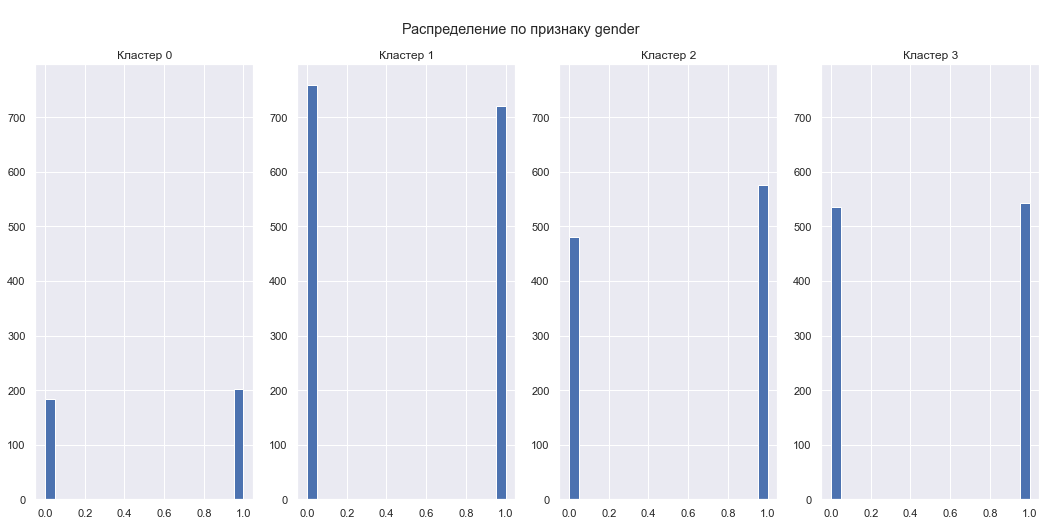

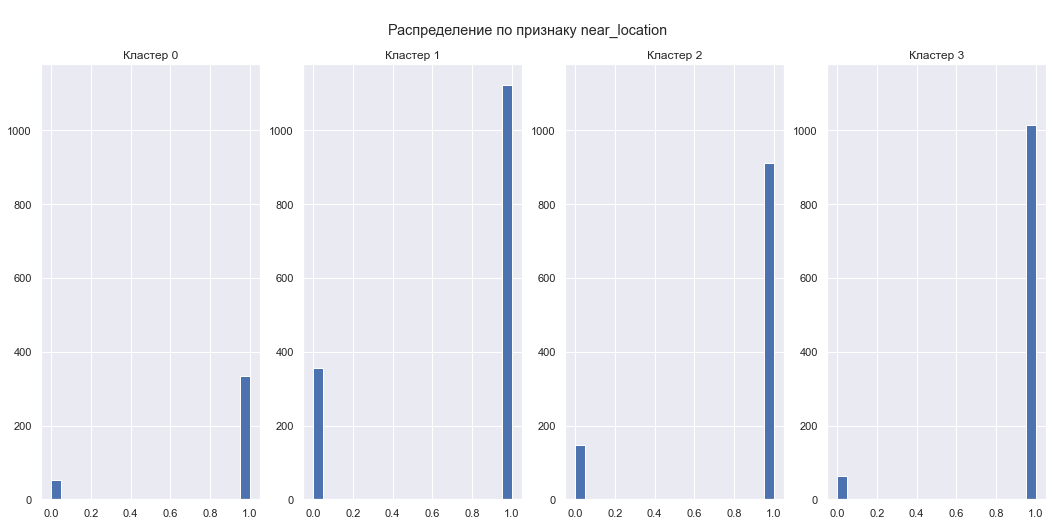

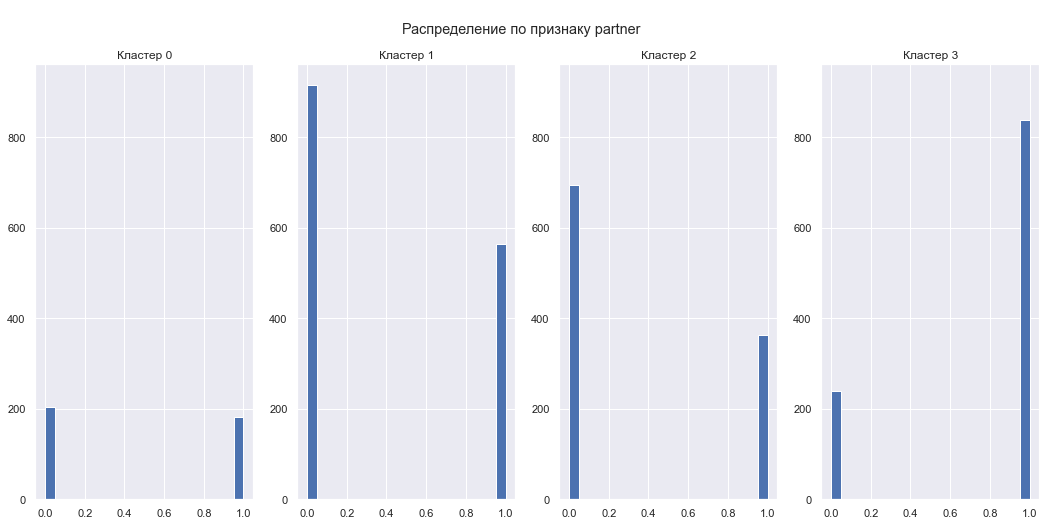

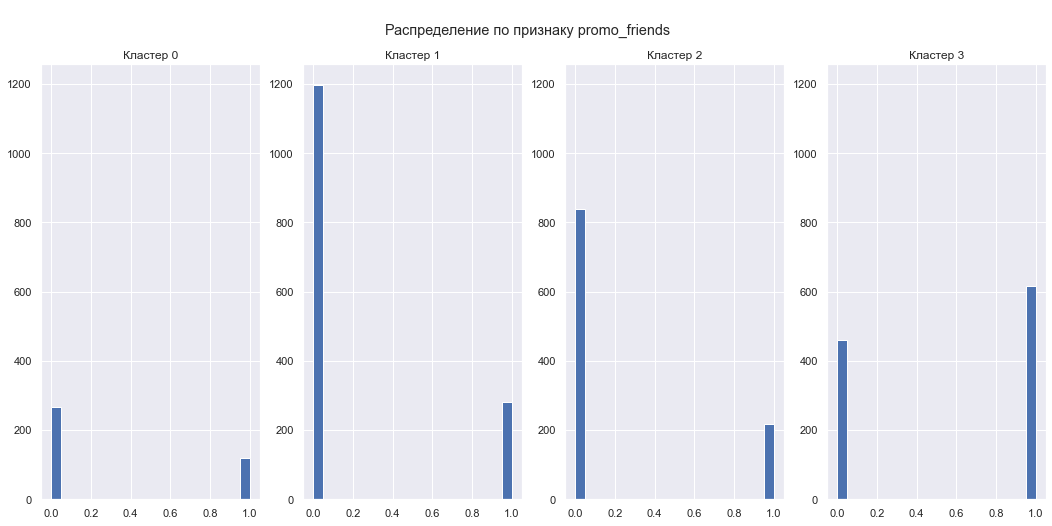

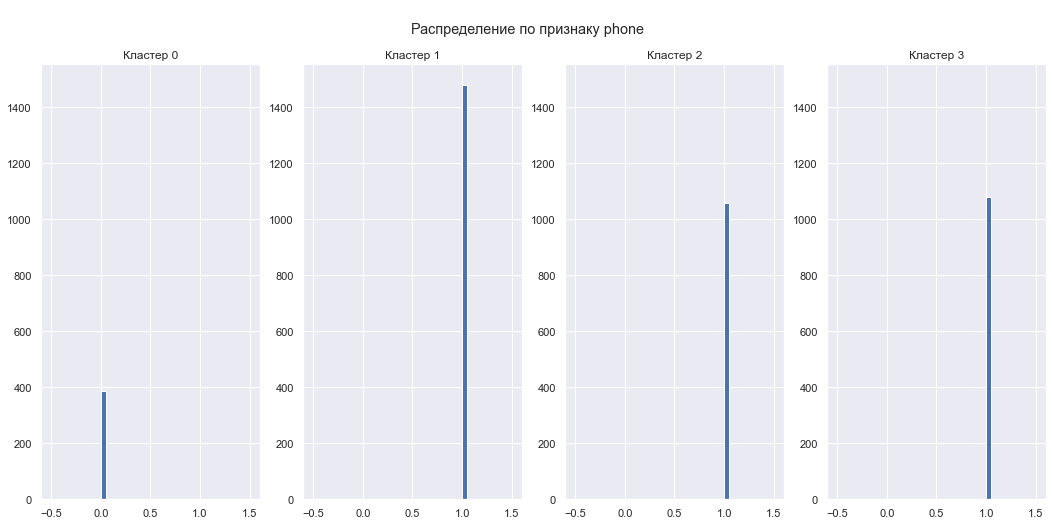

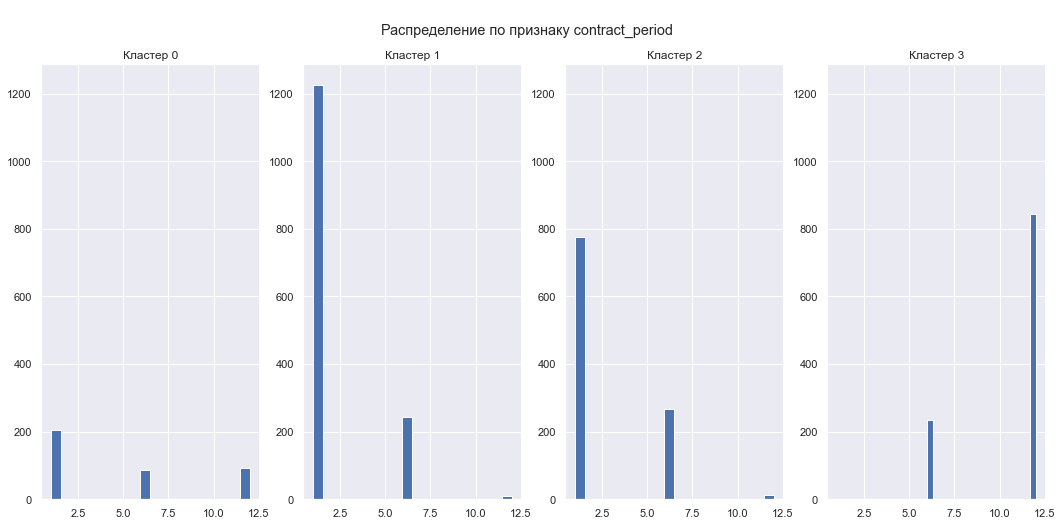

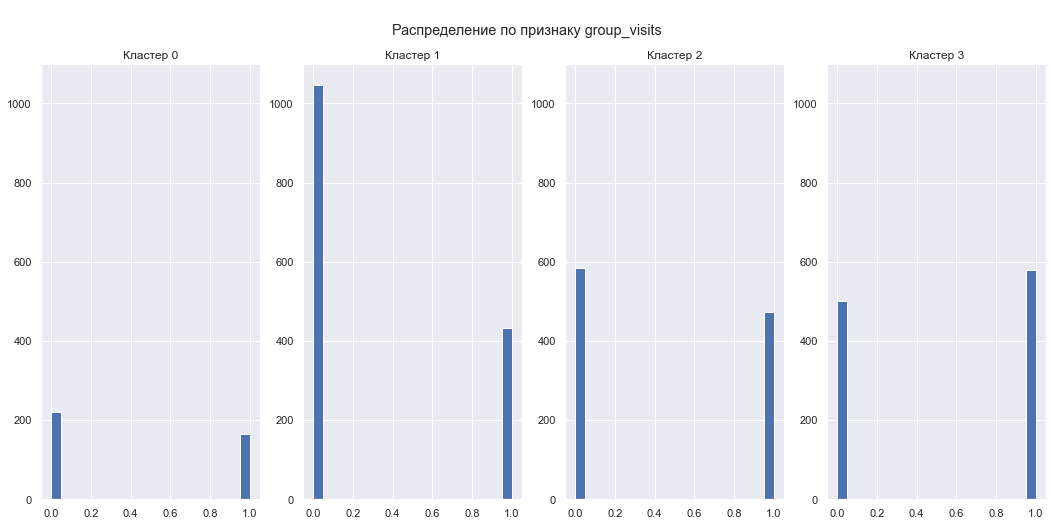

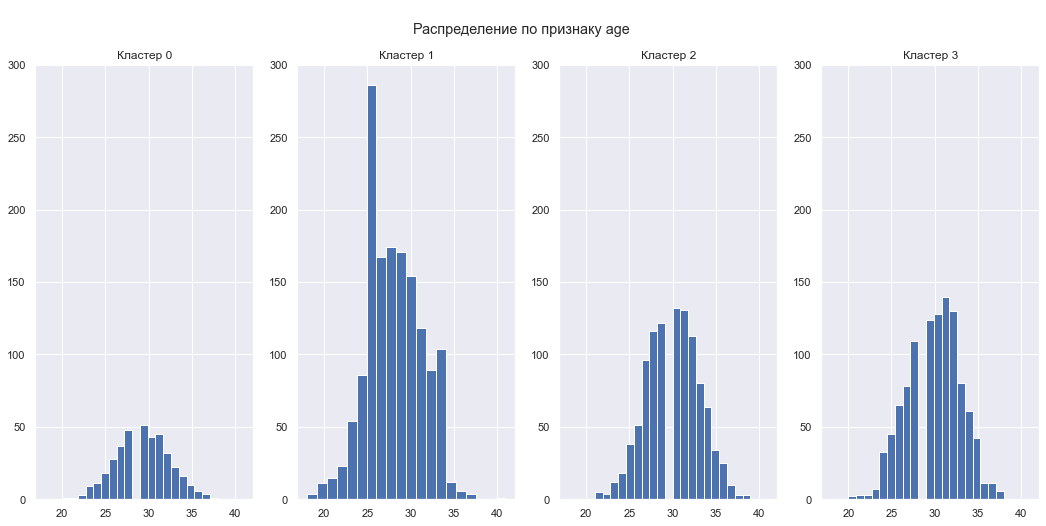

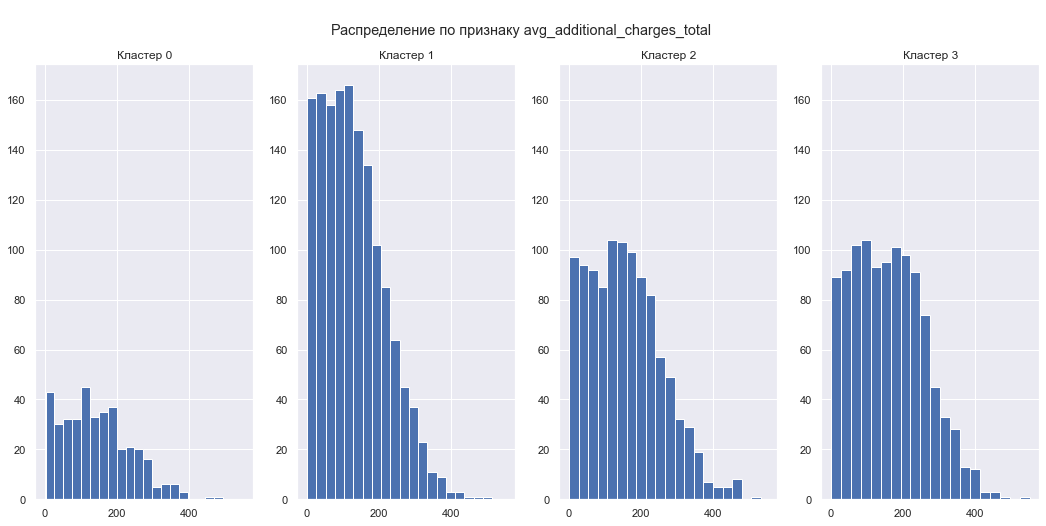

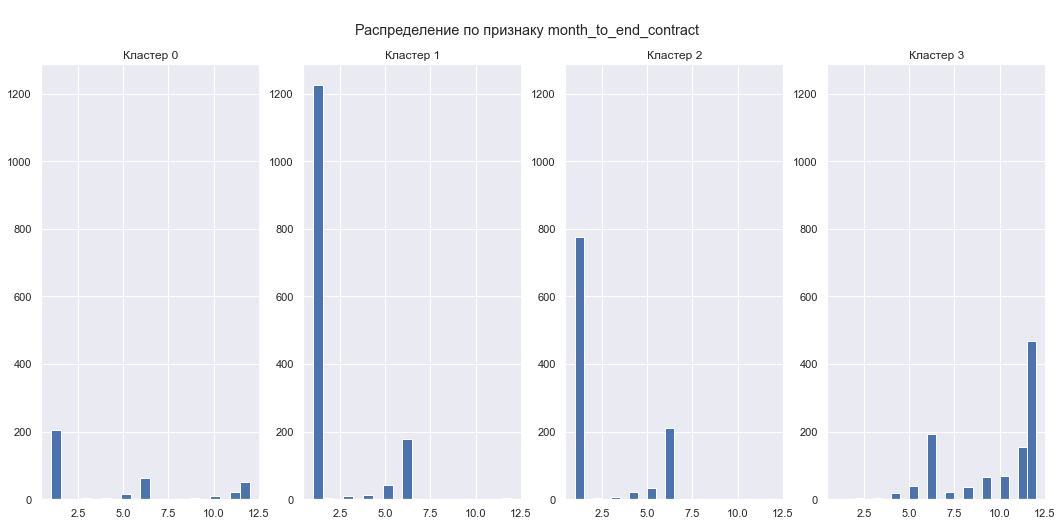

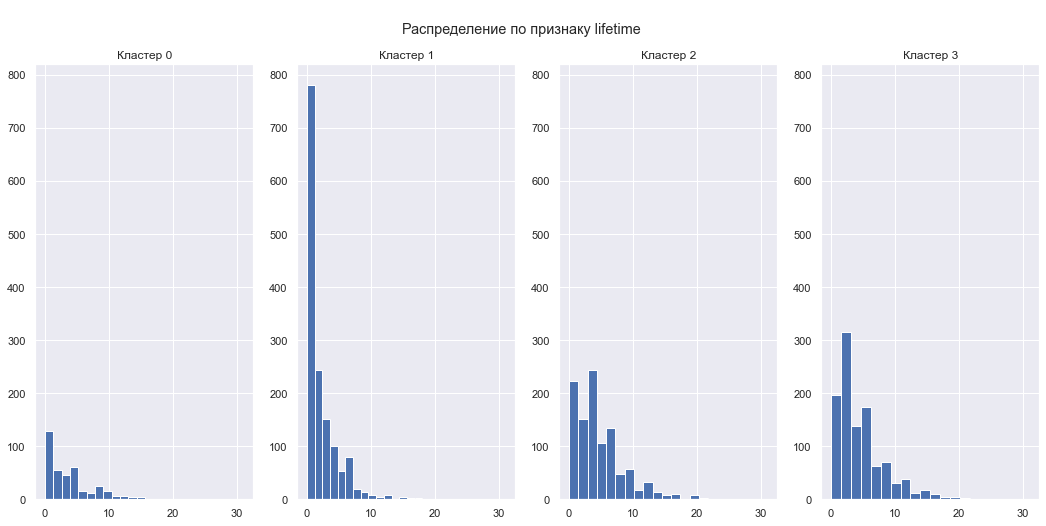

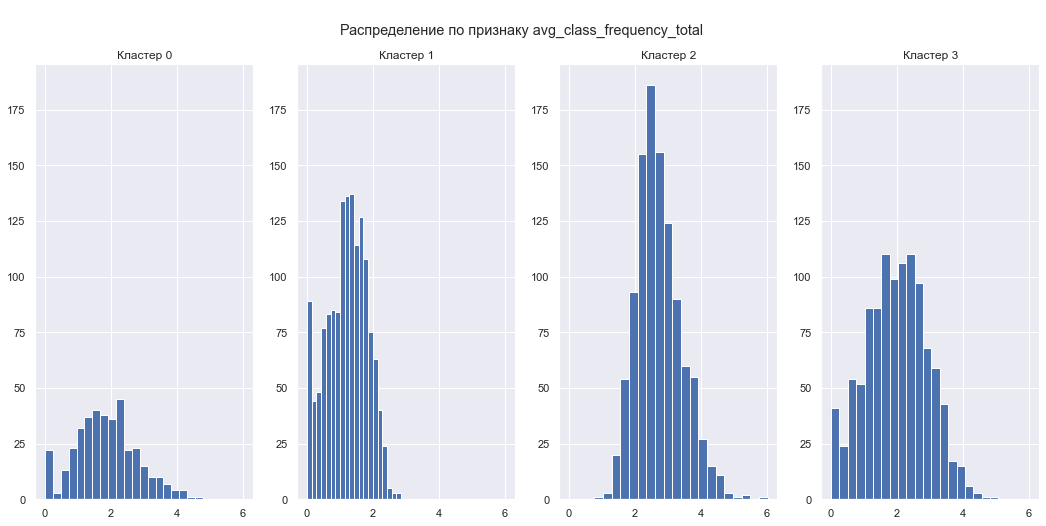

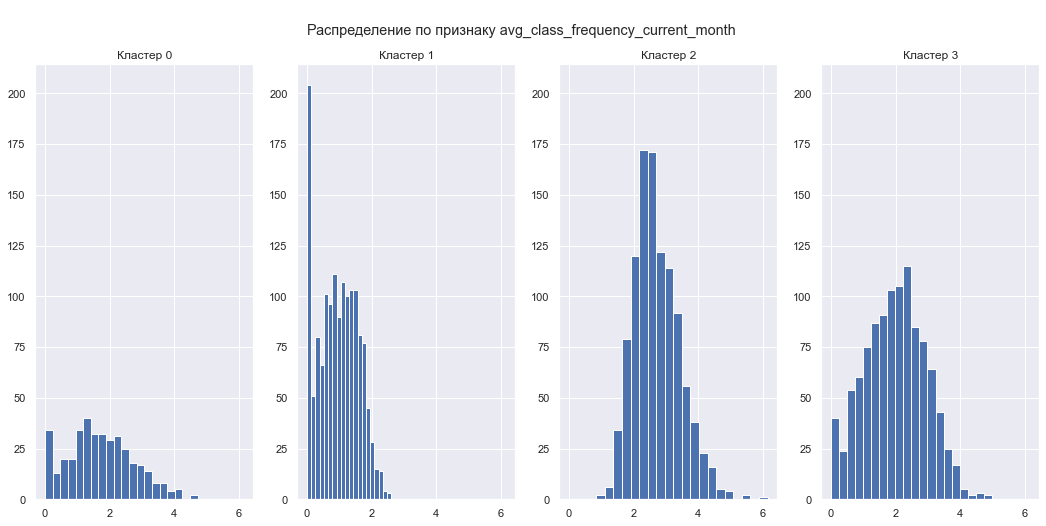

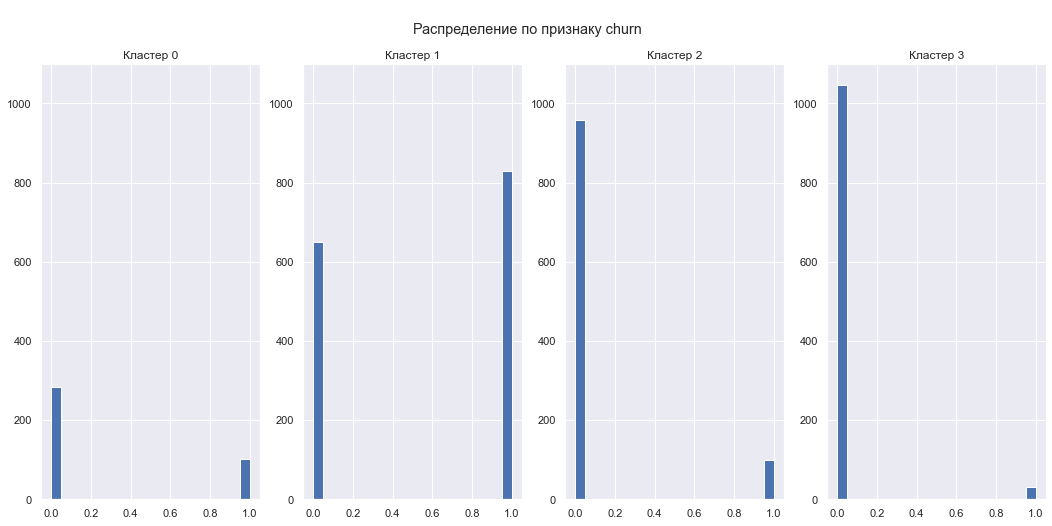

In [61]:
for col in df.drop(['cluster'], axis=1).columns:
    i = 1
    for value in [0, 1, 2, 3]:
        ax = plt.subplot(141)
        plt.subplot(i, 4, value+1, sharex=ax, sharey=ax)
        plt.suptitle('\nРаспределение по признаку {}'.format(col))
        plt.hist(df.loc[df['cluster'] == value, col], bins=20)
        plt.title('Кластер {}'.format(value))        
    plt.show()
    i = i+1

Опишем увиденное:
- `gender` - классы распределились в равных пропорциях во всех кластерах;  
- `near_location` - соотношения колеблются от кластера к кластеру, но везде преобладает значение 1;  
- `partner` - только у третьего кластера больше значений 1, чем 0 (причём сильно больше);
- `promo_friends` - только у третьего кластера больше значений 1, чем 0;
- `phone` - в нулевом кластере только 0, в остальных только 1;
- `contract_period` - в третьем кластере только 6 и 12, в первом и втором почти нет 12, в нулевом есть 1, 6 и 12.
- `group_visits` - только у третьего кластера больше значений 1, чем 0. У первого кластера сильно больше значений 0, чем 1;
- `age` - в нулевом, втором и третьем кластерах провалы в распределениях в районе 29 лет;
- `avg_additional_charges_total` - распределения у второго и третьего кластеров совсем немного смещены в сторону больших значений по сравнения с распределениями у нулевого и первого;
- `month_to_end_contract` - третий кластер тяготеет к большему количеству месяцев, остальные наоборот. У первого и второго кластеров нет значений больше 6;
- `lifetime` - первый кластер ставит рекорд по скорости оттока;
- `avg_class_frequency_total` - второй и третий кластеры смещены в сторону большей частоты посещений, первый кластер явно смещён в сторону меньшей;
- `avg_class_frequency_current_month` - та же картина: второй и третий кластеры смещены в сторону большей частоты посещений, первый кластер явно смещён в сторону меньшей;
- `churn` - следует помнить, что этот столбец не участвовал в кластеризации, и мы видим его распределение как результат распределения других признаков. Самая низкая доля оттока у третьего кластера. За ним идут: 2, 0, 1. У первого кластера доля оттока практичекси 56%. 

Стоит заметить, что значение в столбце `month_to_end_contract` обновляется каждый месяц в сторону уменьшения. И клиента перетягивает из нулевого кластера в третий (от меньшего оттока к большему). С признаком `lifetime` обратная ситуация, пусть и не столь ярко выраженная.

Всё ещё сложно выделить какие-то явные принципы, по которым сформировались кластеры. И это совсем неудивительно с получившейся низкой метрикой силуэта, равной 0.13.

<a id='s5'></a>
## Шаг 5. Выводы и рекомендации

<a id='s5.1'></a>
#### Датасет

Датасет был доработан:
- названия столбцов приведены к змеиному регистру;
- тип данных у столбца `month_to_end_contract` изменён с вещественного на целочисленный.

Следует выяснить у ответственных за это людей, по каким принципам меняются значения в столбцах `lifetime` ,`churn` и `avg_class_frequency_current_month`. Возможно, эти приципы не логичны или не соблюдаются.

<a id='s5.2'></a> 
#### Исследовательский анализ данных

Меньше отток среди тех, кто:
- живёт или работает возле фитнес-клуба;
- является сотрудником компании-партнёра клуба;
- пришёл по акции "приведи друга";
- посещает групповые занятия;
- старше;
- больше тратит на дополнитеные услуги;
- имеет меньший срок до конца абонемента;
- чаще ходит (причём недельная посещаемость в месяц, предшествующий тому, когда клиент бросает фитнес, падает почти в полтора раза по сравнению с посещаемостью за всё время);
- ходит дольше (суперлогично).

Пол и наличие контактного телефона не оказывают влияния на отток.

42% клиентов, купивших в текущем месяце абонемент на месяц, уйдут в отток. Из тех, кто купил на полгода, уйдёт каждый восьмой. Из обладателей годового абонемента - каждый 42-й.

Есть две пары признаков с очень высокой корреляцией: `month_to_end_contract` (срок до окончания текущего действующего абонемента) в паре с `contract_pediod` (длительность текущего действующего абонемента) (корреляция 0.97) и `avg_class_frequency_total` (средняя частота посещений в неделю за все время с начала действия абонемента) в паре с `avg_class_frequency_current_month` (средняя частота посещений в неделю за предыдущий месяц) (корреляция 0.95).

<a id='s5.3'></a> 
#### Обучение модели

Были обучены две модели: одна методом логистической регрессии, другая методом случайного леса. Первая была признана более удачной с точки зрения метрики `roc_auc (площадь под кривой ошибок)` и для неё был подобран кастомный порог. При подборе кастомного порога не удалось увеличить `F1-меру (сводная метрика, учитывающая баланс между точностью и полнотой)`, но удалось уравнять между собой метрики `precision (доля правильных ответов только среди целевого класса ("отток" = "да"))` и `recall (доля обнаруженных реальных объектов целевого класса)`. Метрики, рассчитанные для кастомного порога:

In [60]:
print('Метрики для прогноза с кастомным порогом:')
print('Accuracy for custom: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precision for custom: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Recall for custom: {:.2f}'.format(recall_score(y_test, custom_predictions)))
print('F1 for custom: {:.2f}'.format(f1_score(y_test, custom_predictions)))

Метрики для прогноза с кастомным порогом:
Accuracy for custom: 0.91
Precision for custom: 0.83
Recall for custom: 0.83
F1 for custom: 0.83


При необходимости модель можно доработать либо в сторону увеличения метрики `precision`, либо в сторону увеличения `recall`, - в зависимости от принятой тактики удержания клиентов. Метрика `recall` полезна, если бизнесу выгоднее предпринять какие-то меры для уменьшения оттока, пусть даже покрывая тех, кто не собирался уходить, чем этого не сделать. В противоположном случае выгоднее поднимать метрику `precision`.

<a id='s5.4'></a> 
#### Кластеризация

В соответствии с заданием датасет был разделён на 5 кластеров. Метрика силуэта (показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой) получилась низкой (0.13 (бывает от минус 1 до 1)). Это обусловило сложности при попытках найти особенности у каждого кластера.

Для кластера с самым низким оттоком (3%) характерно:
- больше значений 1 у признака `partner` (сотрудник компании-партнёра клуба);
- больше значений 1 у признака `promo_friends` (пришёл по акции "приведи друга");
- больше значений 1 у признака `group_visits` (групповые занятия);
- абоменементы только на 6 и 12 месяцев;
- большее количество месяцев до истечения абонемента (перекликается с предыдущим пунктом). При этом стоит понимать, что этот признак (в отличие от почти всех остальных) меняется с каждым месяцем и клиент может автоматически перейти в другой кластер.

Для кластера с самым высокий оттоком (56%) характерно:
- маленькое количество месяцев до истечения абонемента;
- самое короткое время с момента первого обращения в фитнес-центр;
- больше доля не посещающих групповые занятия;
- не больше 6 месяцев до конца абонемента;
- самая быстрая скорость оттока;
- низкая частота посещения в неделю (как за всё время, так и за предыдущий месяц).

<a id='s5.5'></a> 
#### Рекомендации

Рекомендуются следующие меры:
- поощрять клиентов в случае очередной покупки абонемента на полгода или год, что уменьшит вероятность оттока и в конечном счёте увеличит вероятность покупки абонемента снова;
- внедрить абонемент на 3 месяца. Он может приглянуться людям, которым не по карману абонемент на больший срок, но хочется скидку. За 3 месяца клиент может втянуться в спорт с большей вероятностью, чем за 1;
- после того, как будет принято решение о тактике уменьшения оттока, доработать модель в сторону увеличения соответствующей метрики;
- разобраться с заполнением признаков `lifetime` ,`churn` и `avg_class_frequency_current_month`, чтобы анализ датасета был качественнее.